In [1]:
from JupyterImport import *
import abc
import h5py
from dataclasses import dataclass
import numpy as np
import os
import sys
import plotly.express as px
import plotly.graph_objects as go
import copy
import logging
from typing import List, Tuple, Union, Optional
logger = logging.getLogger(__name__)
root_logger.setLevel(logging.WARNING)
sys.path.insert(1, r'D:\OneDrive\UBC LAB\GitHub\Python\PyDatAnalysis')
import src.HDF_Util as HDU
import src.CoreUtil as CU
from src.DataStandardize.ExpSpecific.Sep20 import Fixes

In [2]:
# ## Possible fix for an overlapping 'efit_info' empty attr in EA_values group which prevents the true 'efit_info' from loading

# for dat in dats:
#     g = dat.Other.group
#     if (vg := g.get('EA_values', None)) is not None:
#         if 'efit_info' in vg.attrs.keys():
#             del vg.attrs['efit_info']
#             print(f'deleted efit_info in dat{dat.datnum}')
#             g.file.flush()

## Functions that are used below

In [230]:
def my_heatmap_interp(xs: Union[np.ndarray, list], ys: Union[np.ndarray, list], zs: Union[np.ndarray, list], custom_data: Optional[Union[np.ndarray, list]] = None, new_x_len: int = 100, new_y_tol: float = 1, method='nearest'):
    """
    Interpolates all datas in x with method on a new y array determined by the new_y_tol... I.e. If some y values are very close together they will be grouped into a single row.
    
    Args:
        xs: 1D array of x values
        ys: 1D array of y values
        zs: 1D array of z values
        custom_datas: Optional 2D array of customdata values
        new_x_len: Number of x values to interpolate onto
        new_y_tol: tolerance with which to group together y values (i.e. rows of data)
        method: Which scipy interpolation to use. Defaults to 'nearest' which will maintain direct mapping of values back to dats, but can be set to anything else
    Returns:
        (np.ndarray, np.ndarray, np.ndarray, [np.ndarray]): new_xs, new_ys, new_datas, [new_custom_data]
    """
    from scipy.interpolate import interp1d

    old_ys = np.asanyarray(ys).flatten()
    old_xs = np.asanyarray(xs).flatten()
    data = np.atleast_2d(zs)
    if custom_data is not None:
        custom_data = np.swapaxes(np.atleast_2d(custom_data), 0, 1)
        data = np.concatenate((data, custom_data), axis=0)
    
    assert old_xs.shape[0] == data.shape[-1]  # Make sure that there is an x value for each data value
    
    # New grid for data to lie on
    new_x = np.linspace(np.nanmin(xs), np.nanmax(xs), new_x_len)  # 1D x array
    new_y = np.array(sorted(set(CU.my_round(old_ys, prec=3, base=new_y_tol / 2))))
    # new_y = np.array(sorted(set(ys)))  # 1D y array

    # 3D array to hold N 2D datasets for new x, y grid (i.e. data to plot, plus all the hover data)
    new_data = np.ndarray((data.shape[0], len(new_y), len(new_x)), dtype=np.float32)
    
    for i, y_val in enumerate(new_y):
        od = data[:,np.where(np.isclose(old_ys, y_val, atol=new_y_tol/2))]  # Original data per y value
        ox = old_xs[np.where(np.isclose(old_ys, y_val, atol=new_y_tol/2))]  # Original x per y value

        for j, r in enumerate(od):  # For each row of data, interpolate with new x
            interper = interp1d(x = ox, y = r, bounds_error=False, fill_value=np.nan, kind='nearest')
            nr = interper(new_x)
            new_data[j, i] = nr
    
    if custom_data is not None:
        return new_x, new_y, new_data[0], np.moveaxis(new_data[1:], 0, -1)
    else:
        return new_x, new_y, np.squeeze(new_data)
    
def squareify(xs, ys, zs, customdata = None, new_x_len=100, new_y_tol=5, method='nearest'):
    """
    Takes either list of datas, or 2D grid of data and sets the range of x for all non-nan values for each row
    as a range from 0 -> 1 s.t. the data that is returned is a single rectangular block.
    
    Args:
        xs: 1D array of x values
        ys: 1D array of y values
        zs: 1D or 2D array of z values
        custom_datas: Optional 2D array of customdata values
        new_x_len: Number of x values to interpolate onto
        new_y_tol: tolerance with which to group together y values (i.e. rows of data)
        method: Which scipy interpolation to use. Defaults to 'nearest' which will maintain direct mapping of values back to dats, but can be set to anything else
    Returns:
        (np.ndarray, np.ndarray, np.ndarray, [np.ndarray]): new_xs, new_ys, new_datas, [new_custom_data]
    """
    zs = np.asanyarray(zs)
    if zs.ndim == 1 and len(xs) == len(zs):  # Then assume just passing in list of data to squareify directly
        xs, ys, zs, customdata = my_heatmap_interp(xs, ys, zs, customdata, new_x_len, new_y_tol, method=method)
    
    new_xs = list()
    new_ys = list()
    new_zs = list()
    new_customdata = list()
    if customdata is None:
        customdata = [None]*len(ys)
    for y, r, c in zip(ys, zs, customdata):
        num_not_nan = np.sum(~np.isnan(r))
        new_xs.extend(np.linspace(0, 1, num_not_nan))
        new_zs.extend(r[np.where(~np.isnan(r))])
        new_ys.extend(np.array([y]*num_not_nan))
        if c is not None:
            new_customdata.extend(c[np.where(~np.isnan(r))])
    
    if customdata is not None:
#         return [np.array(a) for a in [new_xs, new_ys, new_zs, new_customdata]]
        return my_heatmap_interp(new_xs, new_ys, new_zs, new_customdata, new_x_len=new_x_len, new_y_tol=new_y_tol, method=method)
    else:
#         return [np.array(a) for a in [new_xs, new_ys, new_zs]]
        return my_heatmap_interp(new_xs, new_ys, new_zs, new_x_len=new_x_len, new_y_tol=new_y_tol, method=method)

# Figuring out 2D area of LCT/LP and LCB/LCSS to scan

Trying to make a 2D plot where we scan over the last *X*mV of the weakly coupled transition in LCT (with varying LP to stay on transition) in the x axis. While changing LCB/LCSS in the y axis.

Because changing LCB/LCSS will change where gamma broadening begins, I am going to start with a 2D array of points, and then remove any which are gamma broadened on the right (that should remove a triangular shape of data), and I will remove the inverse from the left (i.e. to maintain *X*mV along LCT everywhere).



## Start with 2D array
LCT/LP are always paired up here

LCB/LCSS are always paired up here

In [299]:
# LCT_lims = (-420, -330)
# LP_lims = (-363, -534)

# LCB_lims = (-710, -670)
# LCSS_lims = (-201, -221)
# CS_target_lims = (4.7, 5.8)

# num_LCT = 40
# num_LCB = 10

# all_lcts = np.linspace(*LCT_lims, num_LCT)
# all_lcbs = np.linspace(*LCB_lims, num_LCB)

def eval_line(x1, y1, m, x):
    """Given coord on line, and gradient, calculates new y value(s) at given x"""
    x = np.asanyarray(x)
    return m*(x-x1)+y1

LCT_LP_coord = (-420, -363)  # Just anywhere on the transition in LCT/LP space 
LP_ratio = -1.9  # How much LP needs to change for 1mV change in LCT to stay on transition

# LCT_lims = (-450, -290)
LCT_lims = (-500, -290)
LP_lims = eval_line(*LCT_LP_coord, LP_ratio, LCT_lims)

LCB_LCSS_coord = (-710, -201)  # Anywhere on transition in LCB/LCSS space
LCSS_ratio = -0.5 # How much LCSS needs to change for 1mV change in LCB to stay on transition

# LCB_lims = (-750, -630)
LCB_lims = (-601.25, -590)
LCSS_lims = eval_line(*LCB_LCSS_coord, LCSS_ratio, LCB_lims)

CS_LCSS_coord = (-201, 4.7)  # Somewhere that gives the best point on CS shape for (LCSS, Target nA)
CS_ratio = -0.055

CS_target_lims = (4.7, 5.8)
CS_target_lims = eval_line(*CS_LCSS_coord, CS_ratio, LCSS_lims)
CS_target_max = 5.8
CS_target_min = 4.5

LCT_spacing = 3
all_lcts = np.arange(*LCT_lims, LCT_spacing)
weakly_coupled_dist = 30  # How far to go into weakly coupled in LCT mV
strongly_coupled_dist = 10  # How far into strongly coupled

LCB_spacing = 2.5
all_lcbs = np.arange(*LCB_lims, LCB_spacing)

# num_LCB = 4
# all_lcbs = np.linspace(*LCB_lims, num_LCB)

lcts, lcbs = np.meshgrid(all_lcts, all_lcbs)

single_scan_duration = 680*1.025  # 50 repeats at 300mV width (600 total) 50mV/s

### Some coordinates of where gamma broadening starts in terms of LCT/LCB

In [300]:
# (LCT, LCB) pairs
# gamma_coords = np.array([(-420, -627), (-440, -606), (-400, -640), 
#                          (-359, -680), (-363, -671), (-377, -655), (-368, -662.5)])
gamma_coords = np.array([(-375, -670), (-336, -710), (-362, -683), (-369, -679)])
gamma_coords = gamma_coords[gamma_coords[:,0].argsort()]

line = lm.models.LinearModel()
start = None
end = None
gamma_fit = line.fit(gamma_coords[:,1][start:end], x=gamma_coords[:,0][start:end])
# gamma_fit

### Lets look at how that lies in our area so far

In [301]:
fig = go.FigureWidget()

fig.add_trace(go.Scatter(mode='markers', x=lcts.flatten(), y=lcbs.flatten(), name='Data coords'))
fig.add_trace(go.Scatter(mode='markers', x=gamma_coords[:,0], y=gamma_coords[:,1], line=dict(color='brown'), name='Start of Gamma broadening'))
fig.add_trace(go.Scatter(mode='lines', x=np.array(LCT_lims), y=gamma_fit.eval(x=np.array(LCT_lims)), name='Fit to Gamma broadening'))



PlU.fig_setup(fig, 'Target Datapoints showing Gamma broadened', 'LCT /mV', 'LCB /mV')

fig

FigureWidget({
    'data': [{'mode': 'markers',
              'name': 'Data coords',
              'type': 'sc…

## Now lets remove datapoints on left and right s.t. data covers last 20mV before gamma broadening

In [302]:
# Eval line fit at every LCT coords
fig2 = copy.copy(fig)
coord_thresh_upper = gamma_fit.eval(x=lcts-strongly_coupled_dist)    
coord_thresh_lower = gamma_fit.eval(x=lcts+weakly_coupled_dist)

reject = np.where(np.logical_or(lcbs > coord_thresh_upper, lcbs < coord_thresh_lower))

accepted = np.ones(lcts.shape, np.bool)
accepted[reject] = 0

fig2.add_trace(go.Scatter(mode='markers', x=lcts[reject], y=lcbs[reject], line=dict(color='red'), name='Rejected datapoints'))

fig2

FigureWidget({
    'data': [{'mode': 'markers',
              'name': 'Data coords',
              'type': 'sc…

### Additional Rejection to account for previous datasets

In [303]:
r_upper = gamma_fit.eval(x=lcts)
r_lower = gamma_fit.eval(x=lcts+20)
add_reject = np.where(np.logical_and(np.logical_and(lcbs > -710, lcbs < -670), np.logical_and(lcbs > r_lower, lcbs < r_upper)))
accepted[add_reject] = 0

In [304]:
lcts_to_use = lcts[accepted].flatten()
lcbs_to_use = lcbs[accepted].flatten()

## Check that the Accepted values are correct

In [305]:
fig3 = copy.copy(fig)
fig3.add_trace(go.Scatter(mode='markers', x=lcts_to_use, y=lcbs_to_use, line=dict(color='orange'), name='Accepted datapoints'))
fig3

FigureWidget({
    'data': [{'mode': 'markers',
              'name': 'Data coords',
              'type': 'sc…

## Now calculate the LP/LCSS values to go along with the LCT/LCB values

In [306]:
lp_line = lm.models.LinearModel().fit(LP_lims, x=LCT_lims)
lps_to_use = lp_line.eval(x=lcts_to_use)

lcss_line = lm.models.LinearModel().fit(LCSS_lims, x=LCB_lims)
lcsss_to_use = lcss_line.eval(x=lcbs_to_use)

cs_target_line = lm.models.LinearModel().fit(CS_target_lims, x=LCB_lims)
cs_targets_to_use = cs_target_line.eval(x=lcbs_to_use)
cs_targets_to_use[np.where(cs_targets_to_use > CS_target_max)] = CS_target_max  # Set max target current (Very rough way to set CS fairly well.)
cs_targets_to_use[np.where(cs_targets_to_use < CS_target_min)] = CS_target_min  # Set min target current (Very rough way to set CS fairly well.)


## Finally, print the values to use!

In [307]:
import datetime
num_datapoints = lcts_to_use.shape[-1]
duration = datetime.timedelta(seconds=num_datapoints*single_scan_duration)

def arr_to_igor_wave(arr: np.ndarray, name):
    def _arr_to_igor_list(a: np.ndarray):
        return f'{{{", ".join([str(v) for v in a.round(1)])}}}'
    
    arr = np.array(arr).flatten()
    s = f'Make/O/FREE {name} = {_arr_to_igor_list(arr[:99])}'
    if len(arr) > 99:
        i = 99
        while i < len(arr):
            s += f'\n{name}[numpnts({name})] = {_arr_to_igor_list(arr[i:i+99])}'
            i += 99
    return s


print(f'Total of {num_datapoints} datapoints\n'
      f'Estimated Duration = {duration}\n'
      f'ETA = {(datetime.datetime.now()+duration).strftime("%H:%M:%S")}\n\n'
      f'{arr_to_igor_wave(lcts_to_use, "LCTs")}\n'
      f'LCTs = LCTs/0.196\n'
      f'{arr_to_igor_wave(lps_to_use, "LPs")}\n\n'
      f'{arr_to_igor_wave(lcbs_to_use, "LCBs")}\n'
      f'{arr_to_igor_wave(lcsss_to_use, "LCSSs")}\n\n'
      f'{arr_to_igor_wave(cs_targets_to_use, "CStargets")}\n'
      f'CStargets = CStargets*1000 //Because actually looks for mV not nA\n')

Total of 67 datapoints
Estimated Duration = 12:58:19
ETA = 12:17:05

Make/O/FREE LCTs = {-473, -470, -467, -464, -461, -458, -455, -452, -449, -446, -443, -440, -437, -476, -473, -470, -467, -464, -461, -458, -455, -452, -449, -446, -443, -440, -479, -476, -473, -470, -467, -464, -461, -458, -455, -452, -449, -446, -443, -440, -482, -479, -476, -473, -470, -467, -464, -461, -458, -455, -452, -449, -446, -443, -482, -479, -476, -473, -470, -467, -464, -461, -458, -455, -452, -449, -446}
LCTs = LCTs/0.196
Make/O/FREE LPs = {-262.3, -268.0, -273.7, -279.4, -285.1, -290.8, -296.5, -302.2, -307.9, -313.6, -319.3, -325.0, -330.7, -256.6, -262.3, -268.0, -273.7, -279.4, -285.1, -290.8, -296.5, -302.2, -307.9, -313.6, -319.3, -325.0, -250.9, -256.6, -262.3, -268.0, -273.7, -279.4, -285.1, -290.8, -296.5, -302.2, -307.9, -313.6, -319.3, -325.0, -245.2, -250.9, -256.6, -262.3, -268.0, -273.7, -279.4, -285.1, -290.8, -296.5, -302.2, -307.9, -313.6, -319.3, -245.2, -250.9, -256.6, -262.3, -268.0, 

# Looking at Data

## Quick CT only scans to check on where Gamma broadening really starts

In [12]:
from src.DataStandardize.ExpSpecific.Sep20 import get_lct_name, get_real_lct
from src.DatObject.Attributes.Transition import i_sense_digamma
from src.DatObject.Attributes import Transition as T

In [311]:
dats = get_dats((9051, 9095+1))
dats.extend(get_dats((9181, 9301+1)))



100% (45 of 45) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (121 of 121) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


In [312]:
for dat in progressbar(dats):
    pars = dat.Transition.avg_fit.params
    pars.add('g', 0, vary=True, min=-50, max=100)
    CU.edit_params(pars, 'theta', 10.3, False)
    try:
        dat.Transition.run_avg_fit(params = pars, fit_func=i_sense_digamma)
    except TypeError:
        dat.Transition.avg_fit.best_values.g = np.nan

100% (166 of 166) |######################| Elapsed Time: 0:00:13 Time:  0:00:13


In [ ]:
fig = go.Figure()
xs = [get_real_lct(dat) for dat in dats]
ys = [dat.Logs.fds['LCB'] for dat in dats]
zs = [dat.Transition.avg_fit.best_values.amp for dat in dats]

fig.add_trace(go.Heatmap(x = xs, y = ys, z = zs))
PlU.fig_setup(fig, 'Gamma', 'LCT /mV', 'LCB /mV')
fig

## And now the Entropy Data

In [313]:
dats = get_dats((9096, 9180+1))
dats.extend(get_dats((9190, 9327+1)))
dats.extend(get_dats((9302, 9389+1)))
for dat in dats:
    Fixes.fix_magy(dat)

100% (85 of 85) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (138 of 138) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
 30% (27 of 88) |#######                 | Elapsed Time: 0:00:00 ETA:   0:00:01WARNING:src.DatObject.Attributes.Transition:LinAlgError encountered, retrying
100% (88 of 88) |########################| Elapsed Time: 0:06:14 Time:  0:06:14


#### Hover template and functions for this section

In [314]:
hover_template = '<br>'.join(['Datnum=%{customdata[0]}',
                              'LCT=%{x:.1f}mV',
                              'LCB=%{y:.1f}mV', 
                              'Data=%{z:.2f}'])
template_funcs = [lambda dat: dat.datnum]

main_info = [
    dict(name='LP*2', func=lambda dat: dat.Logs.fds['LP*2'], precision='.1f'),
    dict(name='LCSS', func=lambda dat: dat.Logs.fds['LCSS'], precision='.1f'),
    dict(name='dS', func=lambda dat: dat.SquareEntropy.Processed.outputs.entropy_fit.best_values.dS, precision='.2f', units='kB'),
]

temp, additional_template = PlU.additional_data_dict_converter(main_info, customdata_start=1)
template_funcs.extend(temp)

extra_info = [
    dict(name='MC temp', func=lambda dat: dat.Logs.temps.mc*1000, precision='.1f', units='mK'),
]
extra_template_funcs, extra_template = PlU.additional_data_dict_converter(extra_info, customdata_start = 4)
extra_template = ''.join(['<extra>', extra_template, '</extra>'])

template_funcs.extend(extra_template_funcs)
hover_template = '<br>'.join([hover_template, additional_template, extra_template])

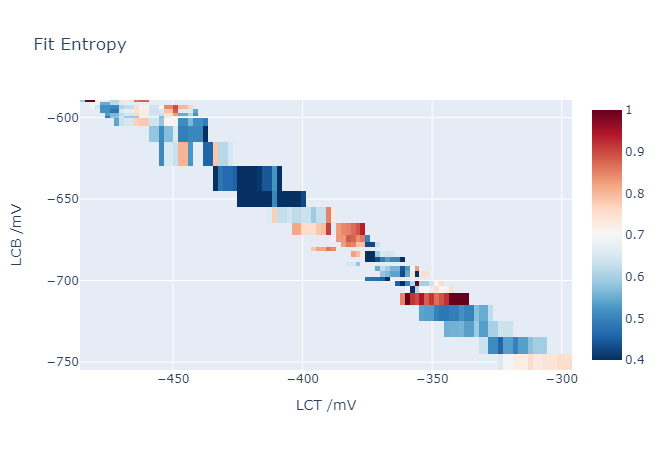

In [323]:
fig = go.Figure()

xs = [get_real_lct(dat) for dat in dats]
ys = [dat.Logs.fds['LCB'] for dat in dats]
zs = [dat.SquareEntropy.Processed.outputs.entropy_fit.best_values.dS for dat in dats]
customdata = np.array([[f(dat) for f in template_funcs] for dat in dats])

xs, ys, zs, customdata = my_heatmap_interp(xs, ys, zs, customdata, new_x_len=100, new_y_tol=0.1, method='nearest')

# xs, ys, zs, customdata = squareify(xs, ys, zs, customdata)

fig.add_trace(go.Heatmap(x = xs, y = ys, z = zs, zmin=0.4, zmax=1, colorscale='RdBu_r',zmid=np.log(2), connectgaps=False, hovertemplate=hover_template, customdata=customdata))
# zs[np.where(np.logical_or(zs < 0.2, zs > 1))] = np.nan
# fig.add_trace(go.Surface(x = xs, y = ys, z = zs, colorscale='RdBu_r', connectgaps=False, hovertemplate=hover_template, customdata=customdata))
PlU.fig_setup(fig, 'Fit Entropy', 'LCT /mV', 'LCB /mV')
# fig.update_layout(template='plotly_dark')
fig

In [316]:
fig.write_html(export_path+'2D Entropy.html')

In [317]:
fits = list()
for dat in progressbar(dats):
    pars = copy.copy(dat.Transition.avg_fit.params)
    pars = CU.edit_params(pars, 'theta', 10.3, False)
    pars.add('g', 0, vary=True, min=-50, max=100)
    
    fits.append(T.transition_fits(x=dat.Transition.x, z=dat.Transition.avg_data[:], params = pars, func=i_sense_digamma, auto_bin=True)[0])

100% (311 of 311) |######################| Elapsed Time: 0:00:19 Time:  0:00:19


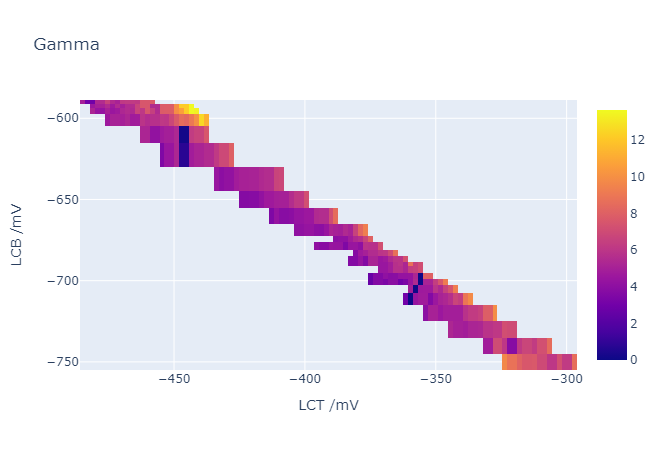

In [318]:
xs = [get_real_lct(dat) for dat in dats]
ys = [dat.Logs.fds['LCB'] for dat in dats]
zs = [fit.best_values['g'] for fit in fits]
customdata = np.array([[f(dat) for f in template_funcs] for dat in dats])

xs, ys, zs, customdata = my_heatmap_interp(xs, ys, zs, customdata, new_x_len=100, new_y_tol=5, method='nearest')

fig2 = go.Figure()
fig2.add_trace(go.Heatmap(x = xs, y = ys, z = zs, zmin=0, zmax=np.nanmax(zs), hovertemplate=hover_template, customdata=customdata))
PlU.fig_setup(fig2, 'Gamma', 'LCT /mV', 'LCB /mV')
fig2

In [319]:
fig.write_html(export_path+'2D Gamma.html')